In [396]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_score 

from sklearn.decomposition import PCA 

from sklearn.cluster import DBSCAN 
from sklearn import mixture 

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [286]:
taxi = pd.read_csv('../data/train.csv')

In [287]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [288]:
taxi.shape

(1458644, 11)

In [289]:
taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Convert pickup and drop off to datetime

In [290]:
taxi.pickup_datetime = pd.to_datetime(taxi.pickup_datetime)
taxi.dropoff_datetime = pd.to_datetime(taxi.dropoff_datetime)

Check values per hour of pickup

In [291]:
taxi.pickup_datetime.map(lambda dt: dt.month).value_counts()

3    256189
4    251645
5    248487
2    238300
6    234316
1    229707
Name: pickup_datetime, dtype: int64

Check values per vendor

In [292]:
taxi.vendor_id.value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Choose only vendor 2 & month of January to create a subset from which we will take a sample to apply the model

In [293]:
subset = taxi[(taxi.vendor_id == 2) & (taxi.pickup_datetime.dt.month == 1)]

In [294]:
subset.shape

(124105, 11)

In [295]:
subset2 = subset.copy()

### Visualize the Data to Gain Insights

#### Exploring longitude & latitude

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


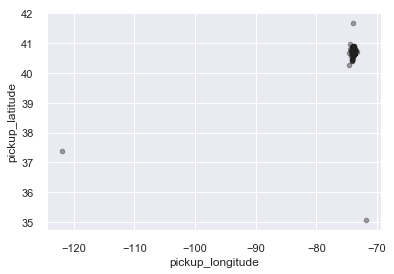

In [296]:
subset2.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4)

- Remove far away destinations to get more clarity on the data for trips that originated & terminated within New York
- The area of NYC we will focus is: latitude between 40.6285 and 40.8408, and longitude between -74.1831 and -73.7608

In [297]:
subset2 = subset2[(subset2.pickup_latitude > 40.6285) & 
        (subset2.pickup_latitude < 40.8408) &
        (subset2.pickup_longitude > -74.1831) & 
        (subset2.pickup_longitude < -73.7608) &
        (subset2.dropoff_latitude > 40.6285) & 
        (subset2.dropoff_latitude < 40.8408) &
        (subset2.dropoff_longitude > -74.1831) & 
        (subset2.dropoff_longitude < -73.7608)]

Also drop the rows with trip duration > 3h as outliers

In [298]:
subset2 = subset2[subset2.trip_duration < 10800]

Use a sample of 10k rows for clustering

In [299]:
df = subset2.sample(15000)

Plot pickup & drop off locations

In [300]:
map_= plt.imread('../NYC.png')

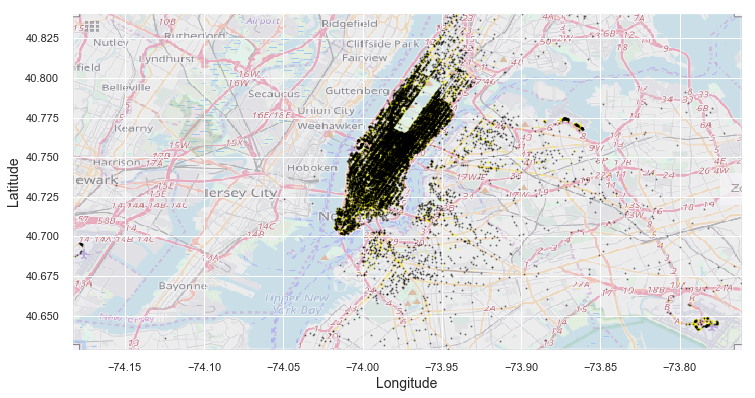

In [301]:
ax = df.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4,
        figsize=(12,10), s = 1, color='yellow')
df.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4,
        figsize=(12,10), s = 1, color='black', ax=ax)

plt.imshow(map_, extent=[-74.1831, -73.7608, 40.6285, 40.8408], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

We can use this information to cluster NYC based on the taxi pickup & dropoff locations and then use this information for further clustering

Check trip duration distribution (convert seconds to hours for plotting purposes)

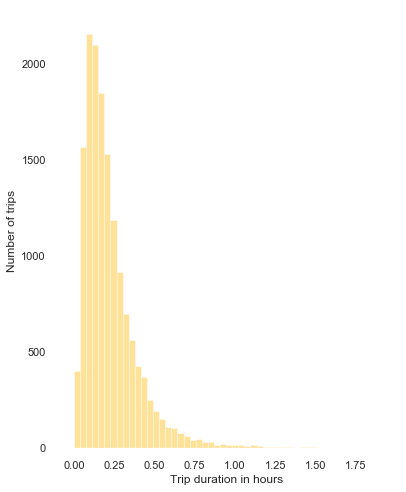

In [302]:
sns.set(color_codes=True)

duration = df.trip_duration/60/60

plt.figure(figsize=(6,8))
ax = sns.distplot(duration, bins=50, kde=False, color='#ffb700')
ax.patch.set_facecolor('white')
plt.xlabel("Trip duration in hours", fontsize=12)
plt.ylabel("Number of trips", fontsize=12)
plt.show()

### K-means clustering for neighbourhoods

Find the optimal number of clusters

In [334]:
df_coordinates = df.copy()

Combine both pickup & dropoff latitudes & longitudes

In [335]:
combined = np.vstack((df_coordinates[['pickup_latitude', 'pickup_longitude']].values,
                    df_coordinates[['dropoff_latitude', 'dropoff_longitude']].values))

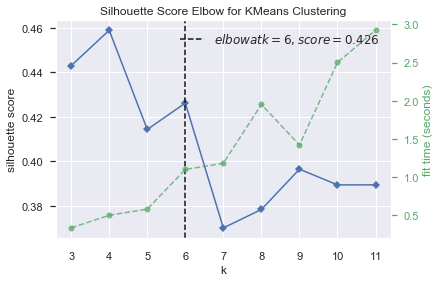

In [305]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='silhouette')
visualizer.fit(combined)
visualizer.poof()

Apply the optimal number of clusters to the model

In [336]:
kmeans = KMeans(n_clusters=6).fit(combined)

In [337]:
df_coordinates.loc[:, 'pickup_neighbourhood'] = kmeans.predict(df_coordinates[['pickup_latitude', 'pickup_longitude']])
df_coordinates.loc[:, 'dropoff_neighbourhood'] = kmeans.predict(df_coordinates[['dropoff_latitude', 'dropoff_longitude']])

Plot results:

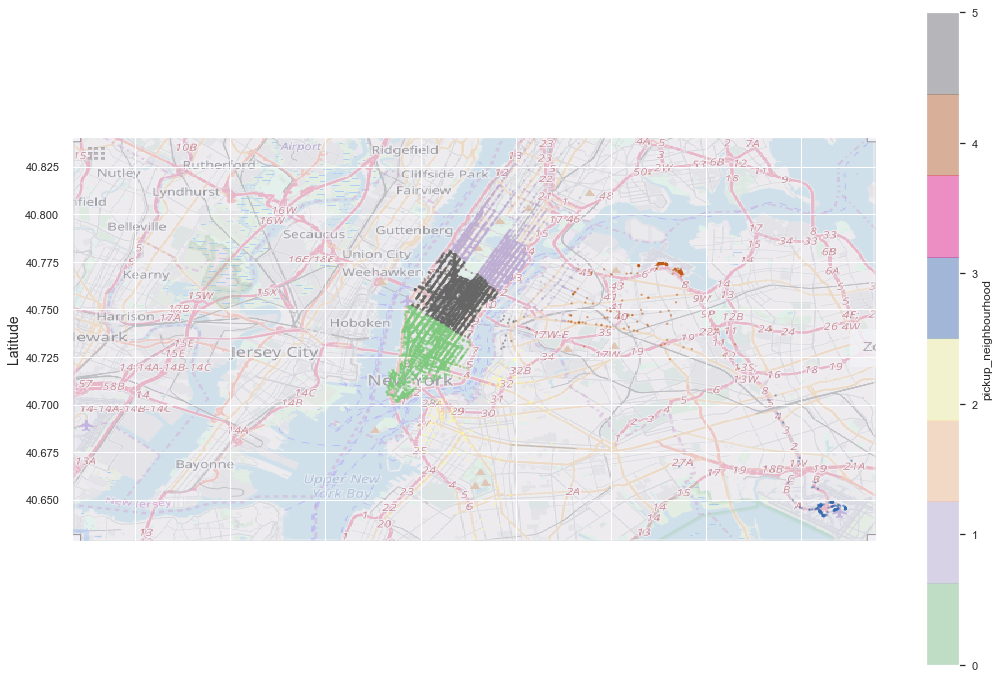

In [338]:
df_coordinates.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', alpha=0.4, 
                      figsize=(18,12), s = 2, c ='pickup_neighbourhood', cmap=plt.get_cmap('Accent'))
plt.imshow(map_, extent=[-74.1831, -73.7608, 40.6285, 40.8408], alpha=0.4)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

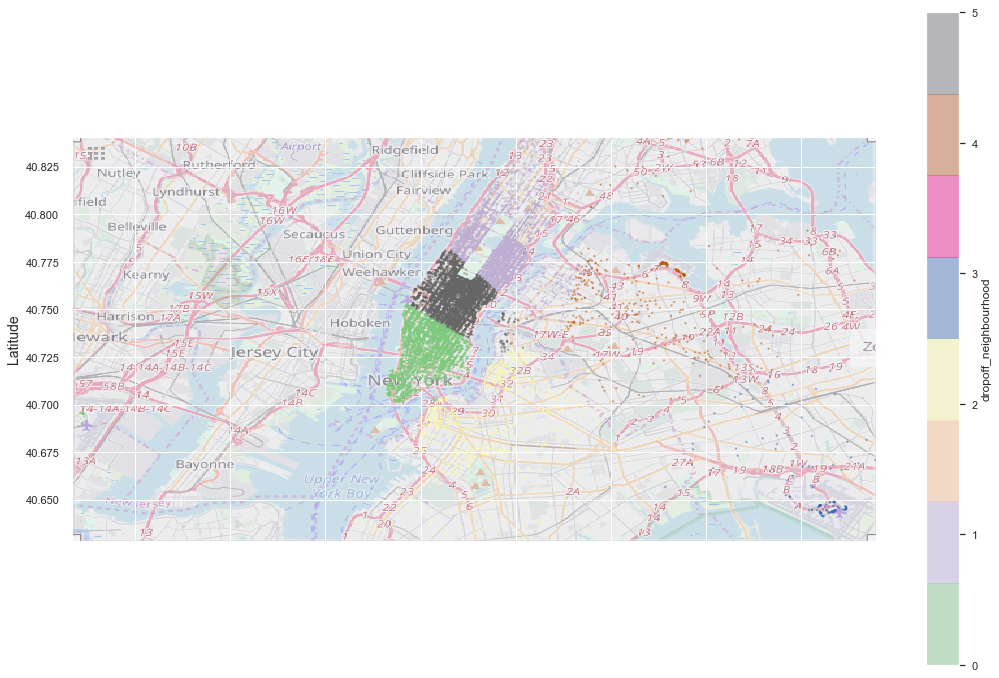

In [339]:
df_coordinates.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', alpha=0.4, 
                      figsize=(18,12), s = 2, c ='dropoff_neighbourhood', cmap=plt.get_cmap('Accent'))
plt.imshow(map_, extent=[-74.1831, -73.7608, 40.6285, 40.8408], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

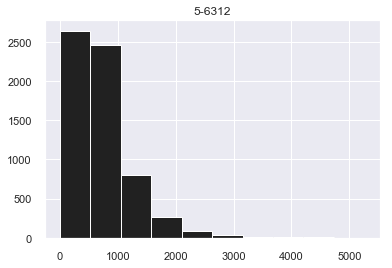

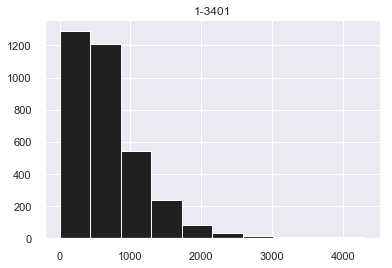

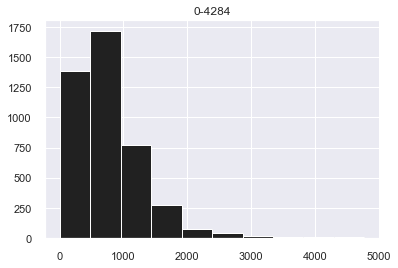

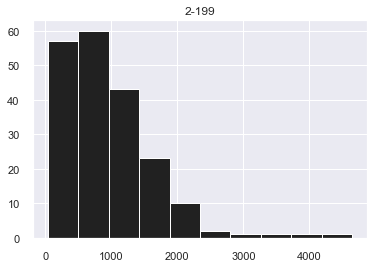

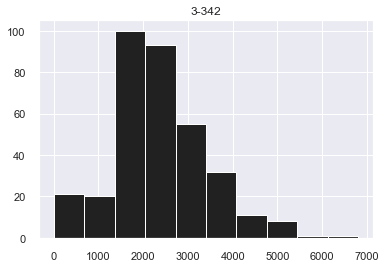

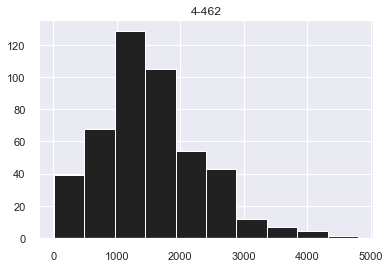

In [340]:
for cluster in df_coordinates.pickup_neighbourhood.unique():
    df_coordinates[df_coordinates['pickup_neighbourhood']==cluster].trip_duration.hist()
    plt.title(str(cluster) + "-" + str(df_coordinates[df_coordinates['pickup_neighbourhood']==cluster].shape[0]))
    plt.show()

Create distance column from pickup to dropoff:

In [341]:
def pandasDistance(row):

    return geopy.distance.distance((row.pickup_latitude, row.pickup_longitude), 
                                   (row.dropoff_latitude, row.dropoff_longitude)).km 

df_coordinates['distance_km'] =  df_coordinates.apply(lambda r: pandasDistance(r), axis=1)

In [342]:
df_coordinates.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km
620875,id3726492,2,2016-01-04 02:14:03,2016-01-04 02:27:34,2,-73.994179,40.751019,-73.956078,40.769451,N,811,5,1,3.813207
1383774,id2982250,2,2016-01-18 12:07:59,2016-01-18 12:10:37,1,-73.984016,40.743549,-73.979523,40.749409,N,158,5,5,0.753273
1278378,id0286061,2,2016-01-14 07:52:04,2016-01-14 07:56:26,5,-73.964333,40.773350,-73.956383,40.784241,N,262,1,1,1.383149
993507,id0192394,2,2016-01-22 07:54:05,2016-01-22 08:01:36,1,-73.939262,40.805080,-73.953979,40.790459,N,451,1,1,2.044288
1022128,id2590369,2,2016-01-15 12:44:05,2016-01-15 12:58:54,1,-74.014900,40.714100,-73.997940,40.740891,N,889,0,0,3.302109


### Further cleaning & data engineering for 2nd clustering

Drop store_and_fwd_flag & vendor_id columns as they are not significant for the clustering, and drop all latitude & longitude information as it's now represented by the cluster information

In [375]:
df_datetime = df_coordinates.copy()

In [376]:
df_datetime.drop(['id', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude'], inplace=True, axis=1)

Feature engineering on datetime: convert pick up and drop off dates to datetime

In [377]:
def get_data(dt):
    return [dt.day, dt.day_name(), dt.hour]

df_datetime['pickup'] = df_datetime.pickup_datetime.map(get_data)
df_datetime['dropoff'] = df_datetime.pickup_datetime.map(get_data)

In [378]:
df_datetime.head()

,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km,pickup,dropoff
620875,2016-01-04 02:14:03,2016-01-04 02:27:34,2,N,811,5,1,3.813207,"[4, Monday, 2]","[4, Monday, 2]"
1383774,2016-01-18 12:07:59,2016-01-18 12:10:37,1,N,158,5,5,0.753273,"[18, Monday, 12]","[18, Monday, 12]"
1278378,2016-01-14 07:52:04,2016-01-14 07:56:26,5,N,262,1,1,1.383149,"[14, Thursday, 7]","[14, Thursday, 7]"
993507,2016-01-22 07:54:05,2016-01-22 08:01:36,1,N,451,1,1,2.044288,"[22, Friday, 7]","[22, Friday, 7]"
1022128,2016-01-15 12:44:05,2016-01-15 12:58:54,1,N,889,0,0,3.302109,"[15, Friday, 12]","[15, Friday, 12]"


In [379]:
df_datetime.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [380]:
column_names = ['pickup_monthday', 'pickup_weekday', 'pickup_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['pickup']]

In [381]:
column_names = ['dropoff_monthday', 'dropoff_weekday', 'dropoff_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['dropoff']]

In [382]:
df_datetime.drop(['pickup', 'dropoff'], inplace=True, axis=1)
df_datetime.head()

,passenger_count,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km,pickup_monthday,pickup_weekday,pickup_hour,dropoff_monthday,dropoff_weekday,dropoff_hour
620875,2,N,811,5,1,3.813207,4,Monday,2,4,Monday,2
1383774,1,N,158,5,5,0.753273,18,Monday,12,18,Monday,12
1278378,5,N,262,1,1,1.383149,14,Thursday,7,14,Thursday,7
993507,1,N,451,1,1,2.044288,22,Friday,7,22,Friday,7
1022128,1,N,889,0,0,3.302109,15,Friday,12,15,Friday,12


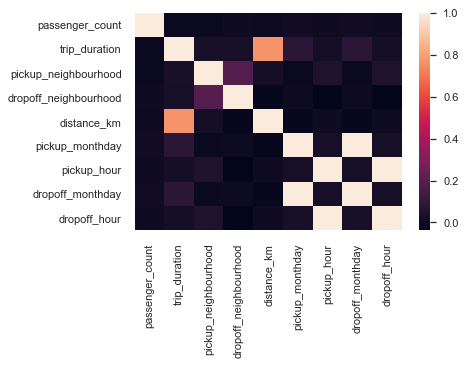

In [383]:
sns.heatmap(df_datetime.corr())

While pickup & drop off are highly correlated, as we're trying to cluster based on trip duration, we will keep this information. We will drop pick up & drop off datetime as we now have the month, hour & day columns

Plot trips by day

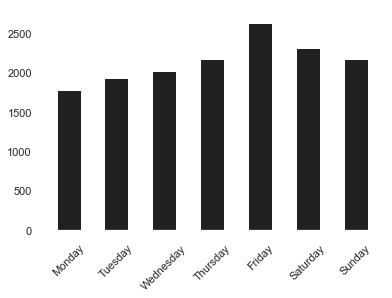

In [384]:
days_grouped = df_datetime.groupby(['pickup_weekday']).count().passenger_count.reset_index()
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = days_grouped['pickup_weekday'].map(mapping)    
days_grouped = days_grouped.iloc[key.argsort()]

ax = days_grouped.plot(kind='bar', x='pickup_weekday', legend = False, color=["#212121","#ffb700"])
ax.set_xticklabels(labels=weekdays, rotation=45)
ax.patch.set_facecolor('white')
plt.xlabel("")
plt.show()

Plot trips by hour

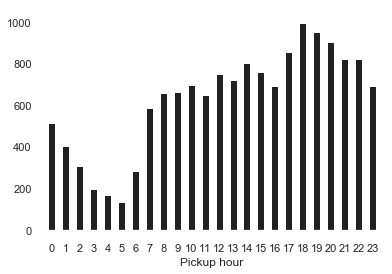

In [385]:
h_grouped = df_datetime.groupby(['pickup_hour']).count().passenger_count.reset_index()
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

ax = h_grouped.plot(kind='bar', x='pickup_hour', legend = False, color=["#212121","#ffb700"])
ax.xaxis.set_tick_params(rotation=0)
ax.patch.set_facecolor('white')
plt.xlabel("Pickup hour")
plt.show()

Plot pickup hours for working days vs weekend

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


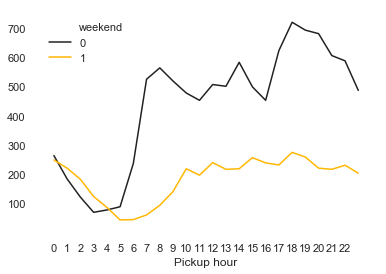

In [386]:
week_vs_wkd = df_datetime[['pickup_weekday', 'pickup_hour', 'passenger_count']]
week_vs_wkd['weekend'] = np.where(week_vs_wkd.pickup_weekday == 'Saturday', 1, 
                                  np.where(week_vs_wkd.pickup_weekday == 'Sunday', 1, 0))
h_grouped = week_vs_wkd.groupby(['weekend', 'pickup_hour']).count().passenger_count.reset_index()

hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

colors = ["#212121","#ffb700"]
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x="pickup_hour", y="passenger_count", hue="weekend", data=h_grouped)
plt.xlabel("Pickup hour")
plt.ylabel("")
ax.patch.set_facecolor('white')
ax.set_xticks(range(0,23))
plt.show()

Do one hot encoding on day, time of day & neigbourhood fields to transform the categorical variable

In [387]:
df_dummies = pd.get_dummies(data=df_datetime, columns=['passenger_count', 'store_and_fwd_flag', 
                                                      'pickup_neighbourhood', 'dropoff_neighbourhood',
                                                      'pickup_monthday', 'pickup_weekday', 'pickup_hour', 
                                                      'dropoff_monthday', 'dropoff_weekday', 'dropoff_hour'])

Apply log to trip distribution to normalize?? Or convert trip_duration to min??

In [389]:
#df_dummies['trip_duration'] = np.log(df_dummies['trip_duration'].values + 1)
df_dummies['trip_duration_min'] = df_dummies['trip_duration']/60
df_dummies.drop('trip_duration', inplace=True, axis=1)

In [390]:
df_dummies.head()

,distance_km,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_N,pickup_neighbourhood_0,...,dropoff_hour_15,dropoff_hour_16,dropoff_hour_17,dropoff_hour_18,dropoff_hour_19,dropoff_hour_20,dropoff_hour_21,dropoff_hour_22,dropoff_hour_23,trip_duration_min
620875,3.813207,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,13.516667
1383774,0.753273,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2.633333
1278378,1.383149,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,4.366667
993507,2.044288,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7.516667
1022128,3.302109,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,14.816667


In [392]:
df_dummies.trip_duration_min.min(), df_dummies.trip_duration_min.max()

(0.05, 113.4)

In [393]:
df_dummies.distance_km.min(), df_dummies.distance_km.max()

(0.0, 26.323026578108912)

### K-Means Clustering

Do further clustering for the new dataset to search for clusters based on pickup & dropoff time/day

Use elbow curve for cluster number

In [468]:
df_ML = df_dummies.copy()

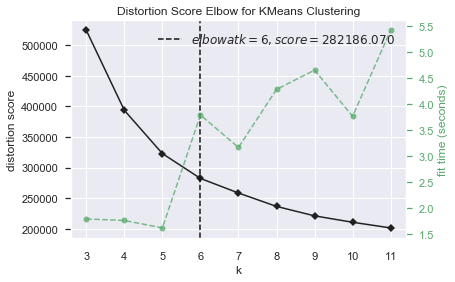

In [395]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='distortion') #distortion=inertia
visualizer.fit(df_ML)
visualizer.poof()

In [469]:
kmeans = KMeans(n_clusters=6, random_state=8)
km1_clusters = kmeans.fit(df_ML)
labels_km1 = km1_clusters.predict(df_ML)

In [470]:
score_km1 = silhouette_score(df_ML, labels_km1, metric='euclidean')
score_km1

0.28346392259009273

In [471]:
df_ML['clusters_km1'] =km1_clusters.labels_
df['clusters_km1'] =km1_clusters.labels_

Plot pickup date vs trip duration

[Timestamp('2016-01-01 00:07:07'), Timestamp('2016-01-31 23:57:41'), 0, 6804]

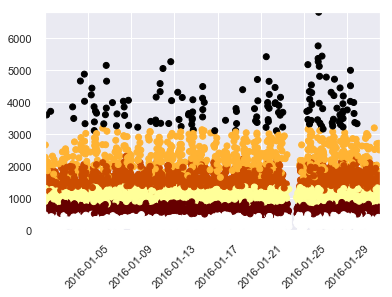

In [472]:
plt.scatter(df.pickup_datetime, df.trip_duration, c = df.clusters_km1, cmap=plt.get_cmap('afmhot')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()])

### Apply PCA to reduce to 2 components

In [401]:
#Reducing the dimensionality of the data to make it visualizable
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(df_dummies) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']

### Apply k-means to PCA dataset

In [473]:
df_ML2 = X_principal.copy()

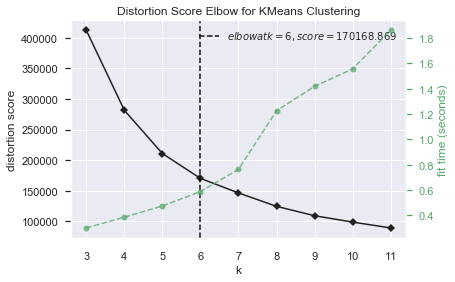

In [403]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='distortion') #distortion=inertia
visualizer.fit(df_ML2)
visualizer.poof()

In [474]:
kmeans_km2 = KMeans(n_clusters=6)
km2_clusters = kmeans_km2.fit(df_ML2)
labels_km2 =km2_clusters.predict(df_ML2)

In [475]:
score_km2 = silhouette_score(df_ML2, labels_km2, metric='euclidean')
score_km2

0.46496162348502296

In [476]:
df_ML2['clusters_km2'] = km2_clusters.labels_
df['clusters_km2'] = km2_clusters.labels_

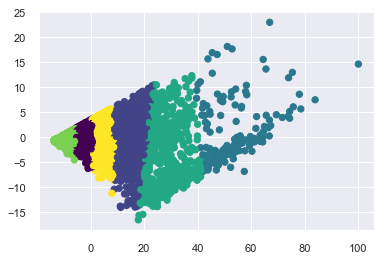

In [477]:
plt.scatter(df_ML2.P1 , df_ML2.P2, c=labels_km2, s=40, cmap='viridis') 

### DBscan

In [478]:
df_ML3 = df_dummies.copy()

In [536]:
# Building the clustering model
clusters_db1 = DBSCAN(eps = 0.3, min_samples = 500).fit(df_ML3) 
labels_db1 = clusters_db1.labels_

In [517]:
score_db1 = silhouette_score(df_ML3, clusters_db1.labels_, metric='euclidean')
score_db1

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [534]:
df_ML3['clusters_db1'] = clusters_db1.labels_
df['clusters_db1'] = clusters_db1.labels_

[Timestamp('2016-01-01 00:07:07'), Timestamp('2016-01-31 23:57:41'), 0, 6804]

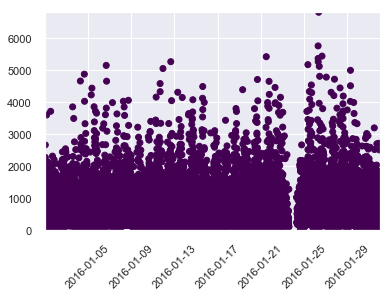

In [537]:
plt.scatter(df.pickup_datetime, df.trip_duration, c = df.clusters_db1, cmap=plt.get_cmap('viridis')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()])

In [504]:
df.clusters_db1.value_counts()

-1    15000
Name: clusters_db1, dtype: int64

### DBscan using PCA dataframe

In [482]:
df_ML4 = X_principal.copy()

In [483]:
# Building the clustering model
clusters_db2 = DBSCAN(eps = 0.5, min_samples = 8).fit(df_ML4) 
labels_db2 = clusters_db2.labels_

In [484]:
score_db2 = silhouette_score(df_ML4, clusters_db2.labels_, metric='euclidean')
score_db2

0.11457496168409367

In [485]:
df_ML4['clusters_db2'] = clusters_db2.labels_
df['clusters_db2'] = clusters_db2.labels_

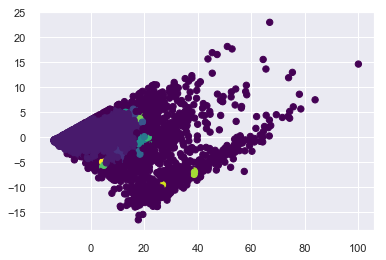

In [486]:
plt.scatter(df_ML4.P1 , df_ML4.P2, c=labels_db2, s=40, cmap='viridis') 

### Gaussian Mixture

In [487]:
df_ML5 = df_dummies.copy()

In [488]:
gmm1 = mixture.GaussianMixture(n_components=6).fit(df_ML5)
labels_gm1 = gmm1.predict(df_ML5)

In [489]:
score_gm1 = silhouette_score(df_ML5, labels_gm1, metric='euclidean')
score_gm1

-0.1426679804903118

In [490]:
df_ML5['clusters_gm1'] = labels_gm1
df['clusters_gm1'] = labels_gm1

[Timestamp('2016-01-01 00:07:07'), Timestamp('2016-01-31 23:57:41'), 0, 6804]

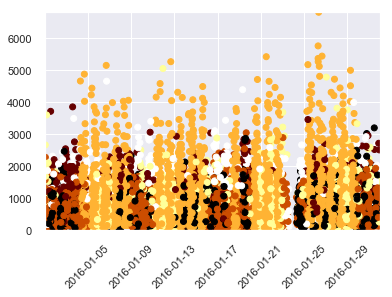

In [491]:
plt.scatter(df.pickup_datetime, df.trip_duration, c = df.clusters_gm1, cmap=plt.get_cmap('afmhot')) 
plt.xticks(rotation=45)
plt.axis([df.pickup_datetime.min(),df.pickup_datetime.max(), 0, df.trip_duration.max()])

### Gaussian Mixture using PCA dataframe

In [492]:
df_ML6 = X_principal.copy()

In [493]:
gmm2 = mixture.GaussianMixture(n_components=6).fit(df_ML6)
labels_gm2 = gmm2.predict(df_ML6)

In [494]:
score_gm2 = silhouette_score(df_ML6, labels_gm2, metric='euclidean')
score_gm2

0.35104103179223556

In [495]:
df_ML6['clusters_gm2'] = labels_gm2
df['clusters_gm2'] = labels_gm2

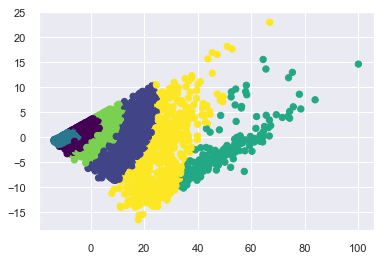

In [496]:
plt.scatter(df_ML6.P1 , df_ML6.P2, c=labels_gm2, s=40, cmap='viridis')

Explore results

In [497]:
df_datetime['clusters_km1'] = km1_clusters.labels_
df_datetime['clusters_gm2'] = labels_gm

In [498]:
df_datetime['trip_duration_min'] = df_datetime.trip_duration/60

In [499]:
# Create labels for trip duration
min_labels = ['<10min', '10-20min', '20-30min', '30-40min', '30-50min', '60-40min', '1-1,5h', '1,5-2h', '>2h']
cutoffs = [-1, 10, 20, 30, 40, 50, 60, 90, 120, 300]
df_datetime['duration_labels_min'] = pd.cut(df_datetime.trip_duration_min, cutoffs, labels=min_labels)

In [500]:
df_datetime.head()

,passenger_count,store_and_fwd_flag,trip_duration,pickup_neighbourhood,dropoff_neighbourhood,distance_km,pickup_monthday,pickup_weekday,pickup_hour,dropoff_monthday,dropoff_weekday,dropoff_hour,clusters_km1,clusters_km2,clusters_db,clusters_gm,trip_duration_min,duration_labels_min,clusters_gm2
620875,2,N,811,5,1,3.813207,4,Monday,2,4,Monday,2,1,1,0,5,13.516667,10-20min,5
1383774,1,N,158,5,5,0.753273,18,Monday,12,18,Monday,12,5,0,0,0,2.633333,<10min,0
1278378,5,N,262,1,1,1.383149,14,Thursday,7,14,Thursday,7,5,0,0,4,4.366667,<10min,4
993507,1,N,451,1,1,2.044288,22,Friday,7,22,Friday,7,5,0,0,0,7.516667,<10min,0
1022128,1,N,889,0,0,3.302109,15,Friday,12,15,Friday,12,4,3,0,0,14.816667,10-20min,0


Group by clusters for the best scoring models and other features to find a relation

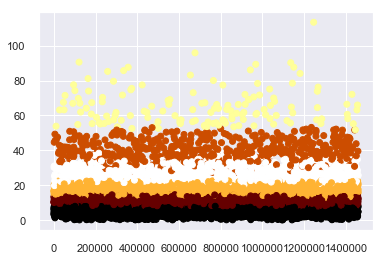

In [538]:
plt.scatter(df_datetime.index, df_datetime.trip_duration/60, c=df_datetime.clusters_km2, 
            cmap=plt.get_cmap('afmhot')) 

In [501]:
pd.crosstab(df_datetime.duration_labels_min,df_datetime.clusters_km2)

clusters_km2,0,1,2,3,4,5
duration_labels_min,,,,,,
<10min,5199,1796,0,0,0,0
10-20min,0,2853,0,2431,0,4
20-30min,0,0,31,494,0,1240
30-40min,0,0,306,0,0,259
30-50min,0,0,217,0,0,0
60-40min,0,0,32,0,53,0
"1-1,5h",0,0,0,0,81,0
"1,5-2h",0,0,0,0,4,0


In [502]:
pd.crosstab(df_datetime.duration_labels_min, df_datetime.clusters_gm2)

clusters_gm2,0,1,2,3,4,5
duration_labels_min,,,,,,
<10min,2268,305,780,455,2191,996
10-20min,1773,244,560,389,1619,703
20-30min,594,92,188,119,549,223
30-40min,201,27,69,34,153,81
30-50min,55,12,23,17,74,36
60-40min,25,2,6,6,36,10
"1-1,5h",24,4,10,8,20,15
"1,5-2h",1,0,0,1,2,0


Create bins for distance and group results

### Hierarchical clustering

In [442]:
df_ML5 = df_dummies.copy()

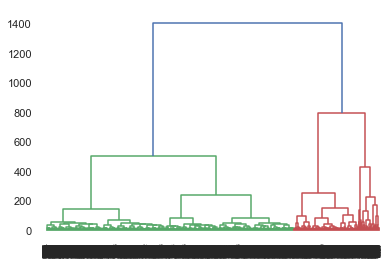

In [455]:
dendrogram = sch.dendrogram(sch.linkage(df_ML5, method='ward'))